# Pneumonia X-Ray Image Classification: EDA

This notebook is for initial exploratory data analysis part for the project. Please see the following for the other notebooks:
* [Splitting Image Files Notebook](02_Splitting_Image_Files.ipynb)
* [Binary Modeling Notebook](03_Binary_Modeling.ipynb)
* [Model Visualization](04_Model_Visualizations.ipynb)
* [Binary Transfer Learning Model](05_Binary_Transfer_Learning.ipynb)
* [Multiclass Modeling](06_Multiclass_Modeling.ipynb)

### Authors

* Mia Fryer
* Arthur Kim
* Ian Sharff

## Overview

According to the Center for Disease Control and Prevention (CDC), [15.7 out of 1000](https://www.cdc.gov/media/releases/2015/p0225-pneumonia-hospitalizations.html) children are diagnosed with pneumonia in a given year, and [~326K children ages 1-4 in the US died in 2018](https://www.cdc.gov/nchs/data/hus/2019/007-508.pdf) from pneumonia and influenza, the third leading medical-related causes of death. In addition, the Association of American Medical Colleges (AAMC) projected that the shortage of physicians in non-primary and non-surgical specialties (i.e. radiology) can reach up to [42,000 by 2033](https://www.aamc.org/news-insights/press-releases/new-aamc-report-confirms-growing-physician-shortage) in the US. Given that pneumonia is still a prevalent issue and that there may be a shortage of physicians who can diagnose patients, healthcare organizations may experience delays in care.

Pneumonia can be diagnosed in several ways such as observing clinical features and symptoms, blood tests, and chest X-rays. Studies, such as [Htun, T.P., Sun, Y., Chua, H.L. et al.](https://www.nature.com/articles/s41598-019-44145-y), have stated that chest X-rays are the "gold standard tool for diagnosing pneumonia...which can distinguish pneumonia from other respiratory tract infection." Based on another [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6377225/), the sensitivity, the ability of a test to correctly identify those with diease or recall, of plain chest radiography in detection of pneumonia is 38-76%.

In this project, we analyzed chest X-ray images of the lungs of children less than 5 years old and developed a image classifier model that can accurately classify if an X-ray image indicates that the child has pneumonia. By utilizing this model, health systems can accurately diagnose patients quickly and effectively, without the need of a physician. In addition, the model could lower the need for additional tests, such as ulstrasounds and CT scans, which could increase costs.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
#set the X and y based on CDC data
X = [r'Congenital' 
     '\n'
     'malformations,'
     '\n'
     'deformations,' 
     '\n'
     'and chromosomal' 
     '\n'
     ' abnormalities',
     'Malignant' 
     '\n'
     'neoplasms',
     'Influenza and'
     '\n'
     'pneumonial',
     'Diseases of'
     '\n'
     'heart',
     'Certain conditions' 
     '\n'
     'originating in'
     '\n'
     ' the perinatal period']

y = [384, 353, 326, 122, 115]

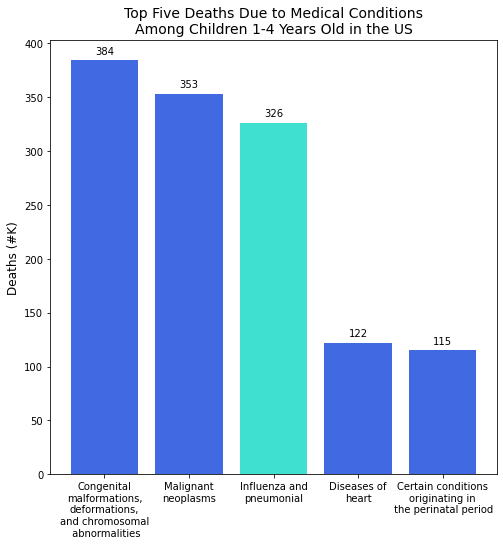

In [6]:
#create a figure
fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')
#set individual bar colors
col = ['royalblue','royalblue','turquoise', 'royalblue', 'royalblue']
#create a bar graph
ax.bar(X, y, color=col)
#set the title and axis label
ax.set_title('Top Five Deaths Due to Medical Conditions'
             '\n'
             'Among Children 1-4 Years Old in the US',
             fontsize=14)
ax.set_ylabel("Deaths (#K)", fontsize=12)

#add in total values at the top of each bar
rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 4, label, ha="center", va="bottom"
    )

plt.show()

#save the figure in the images folder
fig.savefig('images/Top_Five_Deaths.png', bbox_inches='tight')

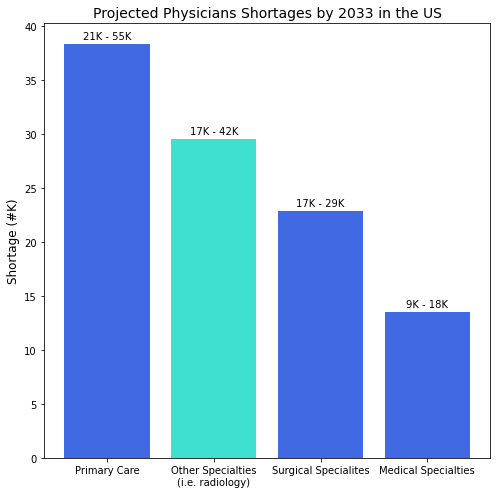

In [7]:
#set X values based on AAMC data
X = ['Primary Care',
     'Other Specialties'
     '\n'
     '(i.e. radiology)',
     'Surgical Specialites',
     'Medical Specialties']

#AAMC gives the shortage data in ranges, so use the mean of the ranges
#as the height of the bar, but use the ranges themselves as the label on
#top of each bar
shortage_lowerbound = [21.4, 17.1, 17.1, 9.3]
shortage_upperbound = [55.2, 41.9, 28.7, 17.8]
average_point = []
labels = []
for i in range(4):
    average_point.append(np.mean([shortage_lowerbound[i],shortage_upperbound[i]]))
    labels.append(str(round(shortage_lowerbound[i]))+'K - '+str(round(shortage_upperbound[i]))+'K')

#create a figure
fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')
#set individual bar colors
col = ['royalblue','turquoise', 'royalblue', 'royalblue']
#create a bar graph
ax.bar(X, average_point, color=col)
#set the title and axis label
ax.set_title('Projected Physicians Shortages by 2033 in the US',
             fontsize=14)
ax.set_ylabel("Shortage (#K)", fontsize=12)

#add in the range of values at the top of each bar
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.25, label, ha="center", va="bottom"
    )

plt.show()

#save the figure in the images folder
fig.savefig('images/Physician_Shortage.png', bbox_inches='tight')

## Business Problem

ACME Health, one of the largest integrated delivery networks (IDNs) in the US, has recently experienced staffing shortages, especially pulmonologists and radiologists. This shortage has been more evident during the COVID-19 pandemic. They have reached out to our team at AIM Consulting LLC to help develop data analytics and modeling tools to mitigate pain points and delays in their processes. After reviewing ACME Health's workflows, we have determined that one of the best ways our team can help is to develop an image classifier model that can accurately identify pneumonia in the lungs of pediatric patients using chest X-ray images.

## Data Understanding

The dataset includes ~5.9K chest X-ray images ( ~4.3K with pneumonia and ~1.6K without pneumonia) of patients ages 1-5 years old. The dataset is from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The pneumonia positive images can be further categorized to bacteria-related and virus-related pneumonia.

## Import

Here we import the relevant libraries to review the data.

In [8]:
import pandas as pd
import os, shutil, random
import matplotlib.pyplot as plt

## Pneumonia vs Non-Pneumonia Images

In [9]:
#create a list of images for each folder (pneumonia and non-pneumonia)
imgs_pneu = [file for file in os.listdir('data/PNEUMONIA') if file.endswith('.jpeg')]
imgs_non_pneu = [file for file in os.listdir('data/NORMAL') if file.endswith('.jpeg')]

In [10]:
#print the number of images in each category
print('There are', len(imgs_pneu), 'pneumonia images')
print('There are', len(imgs_non_pneu), 'non-pneumonia images')

There are 4273 pneumonia images
There are 1583 non-pneumonia images


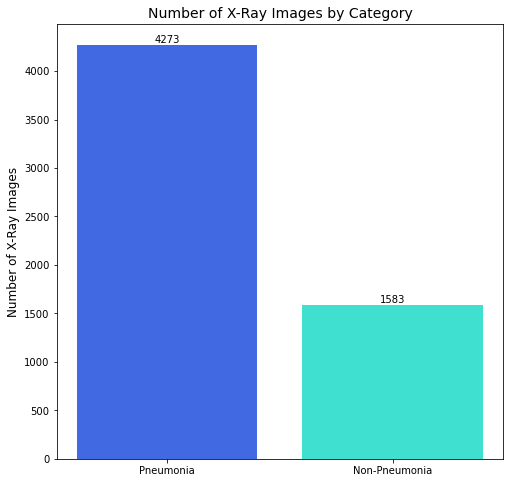

In [11]:
X = ['Pneumonia', 'Non-Pneumonia']
y = [len(imgs_pneu),len(imgs_non_pneu)]

fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')
col = ['royalblue','turquoise']
ax.bar(X, y, color=col)
ax.set_title('Number of X-Ray Images by Category',
             fontsize=14)
ax.set_ylabel("Number of X-Ray Images", fontsize=12)

rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 4, label, ha="center", va="bottom"
    )

plt.show()

#save the figure in the images folder
fig.savefig('images/num_of_images_pneu_vs_non-pneu.png', bbox_inches='tight')

We see that there are more pneumonia positive images than there are non-pneumonia images

In [12]:
#printe the proportion of images in each category
print('Proportion of images with pneumonia:', round(len(imgs_pneu)/(len(imgs_pneu)+len(imgs_non_pneu)),2))
print('Proportion of images without pneumonia:', round(len(imgs_non_pneu)/(len(imgs_pneu)+len(imgs_non_pneu)),2))

Proportion of images with pneumonia: 0.73
Proportion of images without pneumonia: 0.27


In [13]:
#the class imbalance ratio
round(len(imgs_pneu)/len(imgs_non_pneu),1)

2.7

The class imbalance ratio is approximately 3 to 1 for pneumonia vs non-pneumonia, which is not very high.

## Bacterial vs Viral Pneumonia

Each pneumonia images had a label in the file name that indicated if the pneumonia was viral or bacterial.

In [14]:
#create a list of images for each folder (bacteria, virus, non-pneumonia)
imgs_bacteria = [file for file in os.listdir('data/BACTERIA') if file.endswith('.jpeg')]
imgs_virus = [file for file in os.listdir('data/VIRUS') if file.endswith('.jpeg')]
imgs_non_pneu = [file for file in os.listdir('data/NORMAL') if file.endswith('.jpeg')]

In [15]:
print('There are', len(imgs_bacteria), 'pneumonia positive bacteria images')
print('There are', len(imgs_virus), 'pneumonia positive virus images')
print('There are', len(imgs_non_pneu), 'pneumonia negative images')

There are 2780 pneumonia positive bacteria images
There are 1493 pneumonia positive virus images
There are 1583 pneumonia negative images


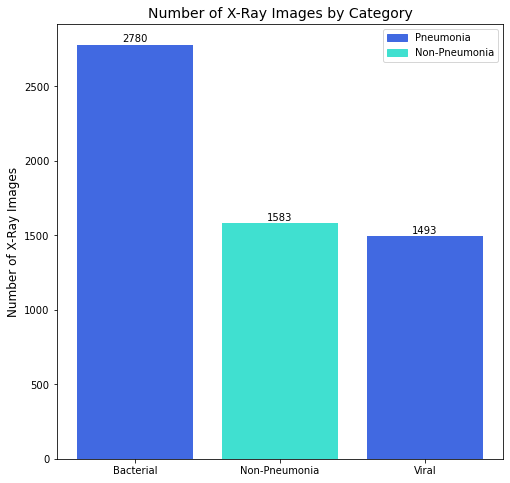

In [16]:
data = [['Bacterial', len(imgs_bacteria), 'Pneumonia'],
        ['Non-Pneumonia', len(imgs_non_pneu), 'Non-Pneumonia'],
        ['Viral', len(imgs_virus), 'Pneumonia']]
df = pd.DataFrame(data, columns = ['category','num_of_images','class'])
fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')

colors = {'Pneumonia':'royalblue', 'Non-Pneumonia':'turquoise'} 
c = df['class'].apply(lambda x: colors[x])
ax.bar(df['category'], df['num_of_images'], color=c)
ax.set_title('Number of X-Ray Images by Category',
             fontsize=14)
ax.set_ylabel("Number of X-Ray Images", fontsize=12)

rects = ax.patches
labels = df['num_of_images']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 4, label, ha="center", va="bottom"
    )
        
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

#save the figure in the images folder
fig.savefig('images/num_of_images_bac_vs_non-pneu.png', bbox_inches='tight')

Note that the total bacteria and virus image is slightly less than the total pneumonia images because some of images (~5 images) in the overall pneumonia file did not have a "virus" or "bacteria" label.

In [17]:
total_num = len(imgs_bacteria) + len(imgs_virus) + len(imgs_non_pneu)
print('Proportion of images with bacterial pneumonia:', round(len(imgs_bacteria)/total_num,2))
print('Proportion of images with viral pneumonia:', round(len(imgs_virus)/total_num,2))
print('Proportion of images without pneumonia:', round(len(imgs_non_pneu)/total_num,2))

Proportion of images with bacterial pneumonia: 0.47
Proportion of images with viral pneumonia: 0.25
Proportion of images without pneumonia: 0.27


When we split pneumonia into bacterial and viral pneumonia, the class imbalance is lower than in the previously analysis above.

## Reviewing Images

In [18]:
vir_samples = [
    'data/VIRUS/person1_virus_11.jpeg',
    'data/VIRUS/person1_virus_12.jpeg',
    'data/VIRUS/person1_virus_13.jpeg',
]

bac_samples = [
    'data/BACTERIA/person1_bacteria_1.jpeg',
    'data/BACTERIA/person1_bacteria_2.jpeg',
    'data/BACTERIA/person10_bacteria_43.jpeg'
]

norm_samples = [
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg'
]

In [19]:
plt.style.use('images/presentation.mplstyle')

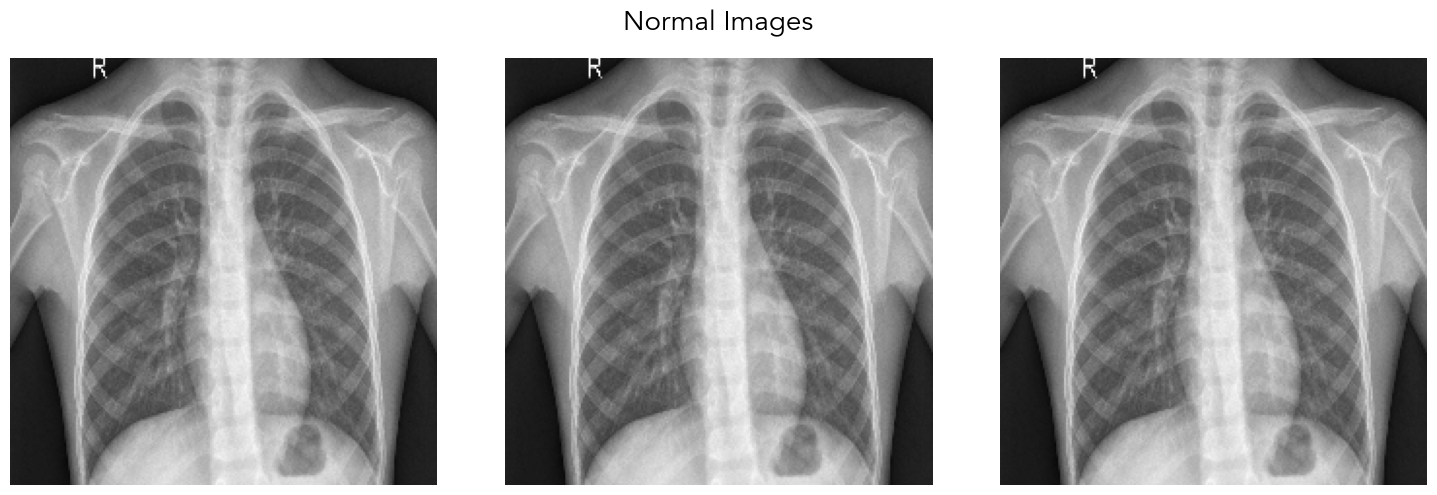

In [22]:
### MAKE FUNCTION
import glob
import cv2

# Path Constants
TRAIN_PATH = 'data/split/train'

normal = glob.glob(TRAIN_PATH+"NORMAL/*.jpeg")
pneumonia = glob.glob(TRAIN_PATH+"PNEUMONIA/*.jpeg")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(norm_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Normal Images")
fig.tight_layout()       
plt.savefig('images/norm_samples.png')
plt.show()

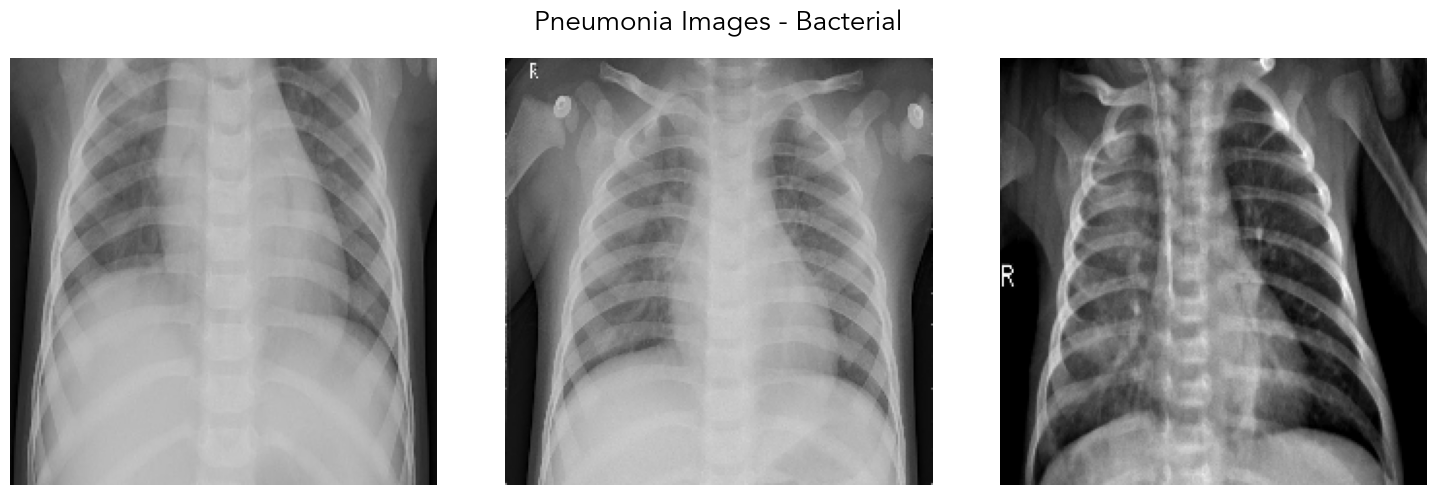

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(bac_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Bacterial")
fig.tight_layout()
plt.savefig('images/bac_samples.png')
plt.show()

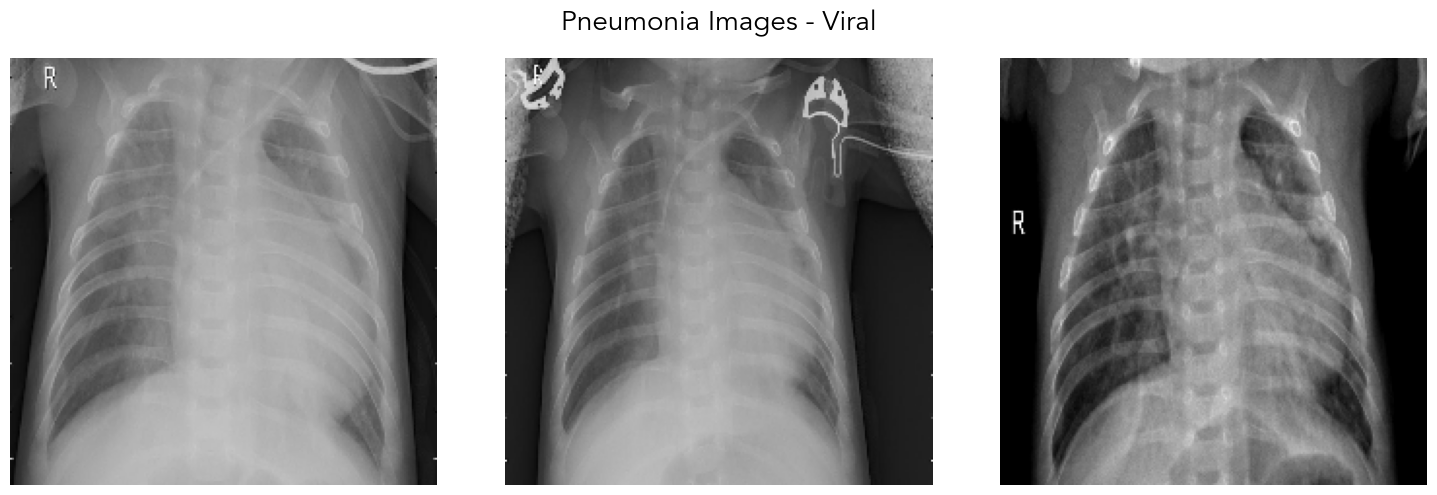

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(vir_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Viral")
fig.tight_layout()
plt.savefig('images/vir_samples.png')
plt.show()